In [1]:
pip install osmnx geopandas

# Extracting Critical Infrastructure in Milan using OSM and GeoPandas

This Python script uses the `osmnx` and `geopandas` libraries to retrieve and process critical infrastructure data from OpenStreetMap (OSM) for the **Metropolitan City of Milan, Italy**. The goal is to identify vulnerable sites (e.g., hospitals, banks, telecom towers) and store them in a clean and unified geospatial dataset.

###  Step-by-Step Description

1. ### **Geocode Milan Boundary**

   ```python
   milan = ox.geocode_to_gdf("Metropolitan City of Milan, Italy")
   ```

   Retrieves the geographic boundary of Milan as a GeoDataFrame using OSM data.

2. ### **Define Vulnerable Site Categories**

   ```python
   vulnerable_tag_options = {
       "hospital": [{"amenity": "hospital"}],
       "power": [{"power": True}],
       ...
   }
   ```

   A dictionary is created that maps each vulnerable infrastructure category (e.g., hospital, power) to one or more OSM tag queries that can identify relevant features.

3. ### **Query and Collect OSM Features**

   ```python
   for label, tag_list in vulnerable_tag_options.items():
       for tags in tag_list:
           gdf = ox.features_from_polygon(...)
   ```

   For each category:

   * It queries OSM for features within the Milan boundary using each tag combination.
   * Filters geometries to include only `Point`, `Polygon`, or `MultiPolygon` types.
   * Tags each feature with its category label.

4. ### **Remove Duplicate Geometries**

   ```python
   category_df = pd.concat(category_features).drop_duplicates(subset=["geometry"])
   ```

   For each category, all retrieved features are merged and deduplicated based on geometry.

5. ### **Combine All Results**

   ```python
   all_sites = pd.concat(collected).reset_index(drop=True)
   ```

   All category-specific features are combined into a single GeoDataFrame.

6. ### **Clean Column Names**

   ```python
   def clean_column_names(columns): ...
   all_sites.columns = clean_column_names(all_sites.columns)
   ```

   Column names are lowercased and made unique (if needed) to ensure consistency and avoid naming conflicts.

7. ### **Save to File**

   ```python
   all_sites.to_file("milan_critical_sites.gpkg", layer="critical_points", driver="GPKG")
   ```

   The final dataset is saved to a GeoPackage (`.gpkg`), a modern and widely supported geospatial file format.

8. ### **Print Summary Statistics**

   ```python
   summary = all_sites.groupby("category").size().reset_index(name="count")
   print(summary)
   ```

   Displays the number of features found for each critical infrastructure category.

---

###  Output

* A single file: `milan_critical_sites.gpkg` containing all critical infrastructure features, each tagged by category.
* A printed summary of feature counts per category.

---

###  Dependencies

* `osmnx`
* `geopandas`
* `pandas`

You can install them via:

```bash
pip install osmnx geopandas pandas
```

---


In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import h3
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# === Step 1: Query Milan boundary and infrastructure ===
print("➤ Geocoding boundary for 'Metropolitan City of Milan'...")
milan = ox.geocode_to_gdf("Metropolitan City of Milan, Italy")
boundary = milan.geometry.iloc[0]

vulnerable_tag_options = {
    "hospital": [{"amenity": "hospital"}],
    "power": [{"power": "substation"}, {"power": "plant"}, {"power": "generator"}, {"power": "switchgear"}],
    "bank": [{"amenity": "bank"}],
    "atm": [{"amenity": "atm"}],
    "fire_station": [{"amenity": "fire_station"}, {"building": "fire_station"}],
    "ambulance_station": [{"amenity": "ambulance_station"}, {"emergency": "ambulance_station"}],
    "gov_office": [{"office": "government"}],
    "telecom": [{"man_made": "mast"}],
    "water_works": [{"man_made": "water_works"}],
    "surveillance": [{"man_made": "surveillance"}],
}

collected = []
for label, tag_list in vulnerable_tag_options.items():
    print(f"\n Querying category: {label}")
    category_features = []
    for tags in tag_list:
        try:
            gdf = ox.features_from_polygon(boundary, tags)
            gdf = gdf[gdf.geometry.type.isin(["Point", "Polygon", "MultiPolygon"])]
            if any(gdf.geometry.type == "MultiPolygon"):
                gdf = gdf.explode(index_parts=False)
            gdf["category"] = label
            category_features.append(gdf)
            print(f"   {tags}: {len(gdf)} features")
        except Exception as e:
            print(f"  ✗ Failed: {tags} — {e}")
    if category_features:
        category_df = pd.concat(category_features).drop_duplicates(subset=["geometry"])
        collected.append(category_df)

if not collected:
    raise RuntimeError("No critical features collected.")

all_sites = pd.concat(collected).reset_index(drop=True)

# === Step 2: Clean columns and project ===
def clean_column_names(columns):
    seen = set()
    clean_cols = []
    for col in columns:
        c = col.lower()
        if c not in seen:
            clean_cols.append(c)
            seen.add(c)
        else:
            suffix = 1
            while f"{c}_{suffix}" in seen:
                suffix += 1
            clean_cols.append(f"{c}_{suffix}")
            seen.add(f"{c}_{suffix}")
    return clean_cols

all_sites.columns = clean_column_names(all_sites.columns)
all_sites = gpd.GeoDataFrame(all_sites, geometry="geometry")
all_sites.set_crs("EPSG:4326", inplace=True)

# === Step 3: Buffer boundary and compute H3 hexagons ===
all_sites_utm = all_sites.to_crs(epsg=32632)
buffered_utm = all_sites_utm.buffer(150)
unioned = buffered_utm.unary_union
boundary_wgs84 = gpd.GeoSeries([unioned], crs=32632).to_crs(epsg=4326).iloc[0]
if boundary_wgs84.geom_type != "Polygon":
    boundary_wgs84 = boundary_wgs84.convex_hull

def h3_hex_to_polygon(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon([(lon, lat) for lat, lon in boundary])

# ↓↓↓ RESOLUTION SET HERE ↓↓↓
resolution = 7
hex_ids = list(h3.polyfill(boundary_wgs84.__geo_interface__, res=resolution))
hex_gdf = gpd.GeoDataFrame({
    "h3": hex_ids,
    "geometry": [h3_hex_to_polygon(h) for h in hex_ids]
}, crs="EPSG:4326")

# === Step 4: Centroids and spatial join ===
all_sites_centroid = all_sites.to_crs("EPSG:32632").centroid.to_crs("EPSG:4326")
all_sites["geometry"] = all_sites_centroid

joined_within = gpd.sjoin(all_sites, hex_gdf, how="inner", predicate="within")
joined_intersects = gpd.sjoin(all_sites, hex_gdf, how="inner", predicate="intersects")
joined = joined_within if len(joined_within) >= len(joined_intersects) else joined_intersects

# Assign dominant category per hex
if not joined.empty and "h3" in joined.columns and "category" in joined.columns:
    grouped = joined.groupby("h3")["category"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    hex_gdf = hex_gdf.merge(grouped, on="h3", how="left")
    hex_gdf = hex_gdf[~hex_gdf["category"].isna()].copy()
else:
    hex_gdf["category"] = None




➤ Geocoding boundary for 'Metropolitan City of Milan'...

 Querying category: hospital
   {'amenity': 'hospital'}: 82 features

 Querying category: power
   {'power': 'substation'}: 593 features
   {'power': 'plant'}: 29 features
   {'power': 'generator'}: 333 features
   {'power': 'switchgear'}: 1 features

 Querying category: bank
   {'amenity': 'bank'}: 902 features

 Querying category: atm
   {'amenity': 'atm'}: 201 features

 Querying category: fire_station
   {'amenity': 'fire_station'}: 22 features
   {'building': 'fire_station'}: 4 features

 Querying category: ambulance_station
  ✗ Failed: {'amenity': 'ambulance_station'} — No matching features. Check query location, tags, and log.
   {'emergency': 'ambulance_station'}: 45 features

 Querying category: gov_office
   {'office': 'government'}: 106 features

 Querying category: telecom
   {'man_made': 'mast'}: 533 features

 Querying category: water_works
   {'man_made': 'water_works'}: 25 features

 Querying category: surveillan

C:\Users\Enric\AppData\Local\Temp\ipykernel_41384\1709214579.py:74: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unioned = buffered_utm.unary_union


# Plot the hexagons

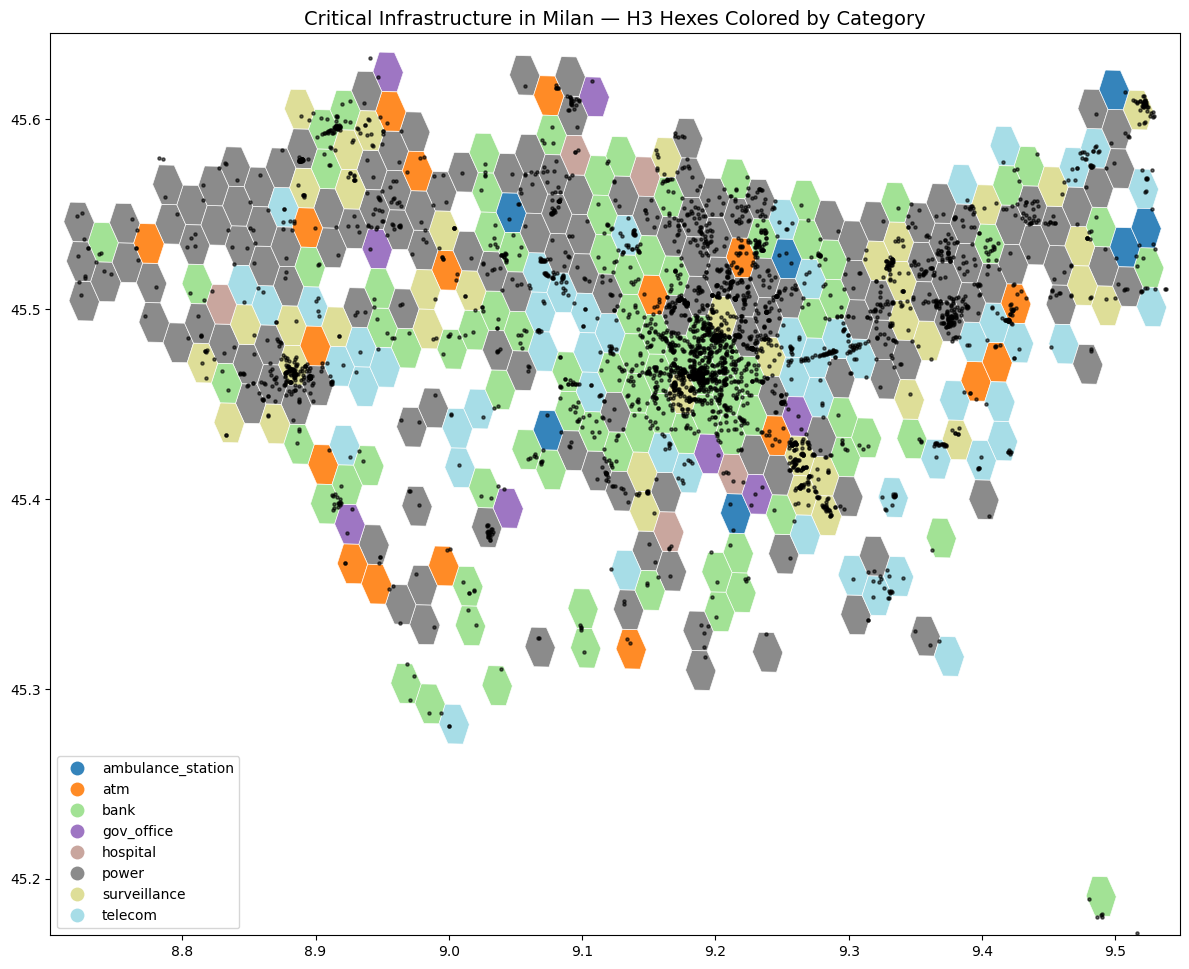

In [3]:
# === Step 5: Plot map ===
import os

# === Ensure 'plots/' directory exists ===
os.makedirs("plots", exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot hexes by category
hex_gdf.plot(
    ax=ax,
    column="category",
    cmap="tab20",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    alpha=0.9
)



# Overlay centroids
all_sites.plot(ax=ax, color="black", markersize=5, alpha=0.6)

# Plot settings
bounds = hex_gdf.total_bounds
ax.set_xlim(bounds[0] - 0.01, bounds[2] + 0.01)
ax.set_ylim(bounds[1] - 0.01, bounds[3] + 0.01)
plt.title("Critical Infrastructure in Milan — H3 Hexes Colored by Category", fontsize=14)
# plt.axis("off")
plt.tight_layout()
plt.savefig("plots/hex_grid_milan.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Create the adjacency matrix

In [4]:
import os
import pandas as pd

# === Step 1: Extract list of H3 indexes ===
h3_indexes = list(hex_gdf["h3"])

# === Step 2: Build adjacency dictionary ===
adj_dict = {h: [] for h in h3_indexes}

for h in h3_indexes:
    neighbors = h3.k_ring(h, 1)
    adj_dict[h] = [n for n in neighbors if n in h3_indexes and n != h]

# === Step 3: Create adjacency matrix DataFrame ===
adj_matrix = pd.DataFrame(0, index=h3_indexes, columns=h3_indexes, dtype=int)

for h, neighbors in adj_dict.items():
    for n in neighbors:
        adj_matrix.loc[h, n] = 1

# === Step 4: Ensure 'csv/' folder exists ===
os.makedirs("csv/adjacency", exist_ok=True)

# === Step 5: Save to CSV ===
adj_matrix.to_csv("csv/adjacency/h3_adjacency_matrix.csv")

print(" Adjacency matrix saved to csv/h3_adjacency_matrix.csv")


 Adjacency matrix saved to csv/h3_adjacency_matrix.csv


# Build the adjagency matrices for each vulnerable class

In [5]:

# Group by infrastructure class
classes = hex_gdf["category"].unique()

for infra_class in classes:
    # Filter the GeoDataFrame by class
    gdf_class = hex_gdf[hex_gdf["category"] == infra_class].copy()

    # Reset index for clean matrix
    gdf_class = gdf_class.reset_index(drop=True)
    gdf_class["id"] = [f"{infra_class[:3].upper()}_{i}" for i in range(len(gdf_class))]

    # Compute adjacency: touch or within 200m
    adjacency_matrix = pd.DataFrame(0, index=gdf_class["id"], columns=gdf_class["id"])

    for i, geom_i in enumerate(gdf_class.geometry):
        for j, geom_j in enumerate(gdf_class.geometry):
            if i != j and (geom_i.touches(geom_j) or geom_i.distance(geom_j) < 200):
                adjacency_matrix.iloc[i, j] = 1

    # Save to CSV
    file_path = f"csv/adjacency/adjacency_{infra_class.lower().replace(' ', '_')}.csv"
    adjacency_matrix.to_csv(file_path)
    print(f" Saved adjacency matrix for {infra_class} to {file_path}")


 Saved adjacency matrix for bank to csv/adjacency/adjacency_bank.csv
 Saved adjacency matrix for telecom to csv/adjacency/adjacency_telecom.csv
 Saved adjacency matrix for power to csv/adjacency/adjacency_power.csv
 Saved adjacency matrix for atm to csv/adjacency/adjacency_atm.csv
 Saved adjacency matrix for surveillance to csv/adjacency/adjacency_surveillance.csv
 Saved adjacency matrix for hospital to csv/adjacency/adjacency_hospital.csv
 Saved adjacency matrix for gov_office to csv/adjacency/adjacency_gov_office.csv
 Saved adjacency matrix for ambulance_station to csv/adjacency/adjacency_ambulance_station.csv


In [6]:
import pandas as pd
import os
from glob import glob

# === Cartella delle matrici di adiacenza per classe ===
adj_dir = "csv/adjacency"
adj_files = glob(os.path.join(adj_dir, "adjacency_*.csv"))

all_hexes = set()
per_class_counts = {}

for f in adj_files:
    df = pd.read_csv(f, index_col=0)
    class_hexes = set(df.index)
    class_name = os.path.basename(f).replace("adjacency_", "").replace(".csv", "")
    per_class_counts[class_name] = len(class_hexes)
    all_hexes.update(class_hexes)

# === Controllo della somma ===
print("\n Hexagon count per class:")
for cls, count in per_class_counts.items():
    print(f"{cls:<20}: {count}")

print(f"\n Total unique hexagons from all classes: {len(all_hexes)}")

# === Confronto con il totale originale ===
original_df = pd.read_csv("csv/adjacency/h3_adjacency_matrix.csv", index_col=0)
total_original = len(original_df)
print(f" Total hexagons in full adjacency matrix: {total_original}")

if len(all_hexes) == total_original:
    print("\nMatch: All class components cover the full set of hexagons.")
else:
    print("\nMismatch: Some hexagons are missing or duplicated across classes.")



 Hexagon count per class:
ambulance_station   : 7
atm                 : 18
bank                : 89
gov_office          : 8
hospital            : 5
power               : 153
surveillance        : 39
telecom             : 54

 Total unique hexagons from all classes: 373
 Total hexagons in full adjacency matrix: 373

Match: All class components cover the full set of hexagons.
